# Finetuning Bert for abstractive summarisation 
In this noteook I want to demonstrate fine-tuning the the model released by Yang Liu and Mirella Lapata for their paper [Text Summarization with Pretrained Encoders](https://arxiv.org/pdf/1908.08345.pdf). I want to start from scratch, as you might if you were approaching this finetuning problem without a tutorial. We will discuss the model and how to pass a new dataset to it. We will then finetune the model on our new dataset and generate some predictions.

The authors released their code and weights [here](https://github.com/nlpyang/PreSumm). However, we will base our code on Rémi Louf's [reimplementation](https://github.com/huggingface/transformers/tree/master/examples/summarization). This uses a more up to date version of Huggingface's Transformers library and is more consise. 

I'm going to assume you are already fairly familiar with the ideas behind BERT. This post will mostly focus on the specifics of using the model. I also recommend you read Yang and Lapata's paper. I will mention their tweaks to the Bert encoder when we come to them. If you just want the final code, have a look in this notebook, or its accompanying Medium post. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from fastai.callbacks import *
import glob
from modeling_bertabs import BertAbsConfig, BertAbs, build_predictor
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from torch.nn import functional as F
from transformers import BertTokenizer, BertModel
import logging
logging.getLogger().setLevel(100)

In [3]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
args = Namespace(
    adam_b1=0.9,
    adam_b2=0.999,
    alpha=0.95,
    batch_size=8,
    beam_size=5,
    block_size=512,
    block_trigram=True,
    data_path="../data/private_dataset.file",
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    max_length=200, 
    min_length=50,
    model_name="temp",
    stories_folder='../data/my_own_stories',
    subset=400,
    train_pct=0.8
)

In [4]:
class SummarisationDataset(Dataset):
    def __init__(self, path, subset=None):
        if path.endswith('.file'):
            self.dataset = pd.read_feather(path)
        if path.endswith('.csv'):
            self.dataset = pd.read_csv(path)
        
        if subset:
            self.dataset = self.dataset.iloc[:subset]
        
    def __len__(self):
         return self.dataset.shape[0]
        
    def __getitem__(self, idx):
        title = ""
        article = self.dataset.iloc[idx]['text']
        article = [s.strip()+'.' for s in article.split('.')]
        article = [self.add_missing_period(line) for line in article if len(line) > 0]
        article = [s for s in article if s not in ['..', '.']]
        
        summary = self.dataset.iloc[idx]['summary']
        summary = [s.strip()+'.' for s in summary.split('.')]
        summary = [self.add_missing_period(line) for line in summary if len(line) > 0]
        summary = [s for s in summary if s not in ['..', '.']]
        
        return title, article, summary
    
    def add_missing_period(self, line):
        END_TOKENS = [".", "!", "?", "...", "'", "`", '"', u"\u2019", u"\u2019", ")"]
        if line.startswith("@highlight"):
            return line
        if line[-1] in END_TOKENS and len(line):
            return line
        return line + "."

In [5]:
data = SummarisationDataset(args.data_path, subset=args.subset)

train_ds, test_ds = train_test_split(data, test_size=1-args.train_pct)
valid_ds, test_ds = train_test_split(test_ds, test_size=0.5)

### Encoding the data for BERTSUM

Let's look at how we would conventionally encode text and pass it to BERT. Here is an example sentence:

In [6]:
sentence1 = "My name is Henry."

We will start off by getting the BertTokenizer from the Transformers repository

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower=True)

Tokenizers from this repo have a few methods we can use. The first, _tokenize()_, will break up a string into Bert style tokens.

In [8]:
tokeized_text = tokenizer.tokenize(sentence1)
tokeized_text

['my', 'name', 'is', 'henry', '.']

The second, _convert_tokens_to_ids()_, will convert these tokens to their numerical equivalents.

In [9]:
numerical_tokens = tokenizer.convert_tokens_to_ids(tokeized_text)
numerical_tokens

[2026, 2171, 2003, 2888, 1012]

We can reverse this by calling _decode()_

In [10]:
tokenizer.decode(numerical_tokens)

'my name is henry.'

Remember though: when we pass text to Bert, we should also pass a [CLS] token at the start of the first sentence and [SEP] tokens at the end of each sentence. Fortunately there is another method, _encode()_, that takes care of this.

In [11]:
encoded_text = tokenizer.encode(sentence1)
encoded_text

[101, 2026, 2171, 2003, 2888, 1012, 102]

If we call _decode()_ on this, we get those tokens as well.



In [12]:
tokenizer.decode(encoded_text)

'[CLS] my name is henry. [SEP]'

To pass this sentence to Bert, we can just grab? the pretrained model using the Transformers API, convert our encoded text to a tensor, and pass it to the model as an argument.

In [13]:
model = BertModel.from_pretrained('bert-base-uncased')
text_tensor = torch.tensor([encoded_text])
model(text_tensor)

(tensor([[[ 0.0131,  0.5101, -0.4724,  ...,  0.0022,  0.1581,  0.7128],
          [ 0.0465,  0.1645, -0.4436,  ..., -0.1006,  0.1616,  0.7363],
          [-0.2963,  0.4691, -0.0759,  ..., -0.3669,  0.2876,  0.3649],
          ...,
          [ 0.4391, -0.3440, -0.2106,  ...,  0.0676,  0.3720,  0.7365],
          [ 0.3724, -0.2132, -0.3207,  ...,  0.2093, -0.0429, -0.5615],
          [ 0.9395, -0.1101, -0.0936,  ...,  0.3332, -0.5686, -0.2744]]],
        grad_fn=<NativeLayerNormBackward>),
 tensor([[-0.9331, -0.5581, -0.9425,  0.8893,  0.8785, -0.2383,  0.9064,  0.3685,
          -0.8970, -1.0000, -0.7138,  0.9930,  0.9863,  0.6877,  0.9614, -0.8641,
          -0.5556, -0.6808,  0.4099, -0.3153,  0.7553,  1.0000, -0.1938,  0.5261,
           0.5817,  0.9987, -0.8773,  0.9546,  0.9767,  0.7685, -0.6838,  0.3427,
          -0.9953, -0.1891, -0.9334, -0.9904,  0.6037, -0.7324, -0.1873,  0.0403,
          -0.9549,  0.4333,  1.0000, -0.2624,  0.6050, -0.4379, -1.0000,  0.4733,
          -0.91

That was easy! Let's do the same thing but with a pair of sentences now.

In [14]:
sentence2 = "What is yours?"

We can pass both sentences to the tokenizer as a pair of arguments. Notice how it prepends the [CLS] token (encoded as 101) to the start of the first sentence and adds the [SEP] token (encoded as 102) to the end of both sentences.

In [15]:
encoded_text = tokenizer.encode(sentence1, sentence2)
text_tensor = torch.tensor([encoded_text])
text_tensor

tensor([[ 101, 2026, 2171, 2003, 2888, 1012,  102, 2054, 2003, 6737, 1029,  102]])

Now we have multiple sentences, there is another aspect we need to consider. Bert actually takes more than just the encoded text as input. It also takes segment embeddings which tell it when one sentence ends and the other begins. These embeddings take the value 0 for the first sentence and 1 for the second sentence. Since we only passed one sentence to model last time, we didn't have to consider this. Behind the scenes, the Transformers library did something like this:

In [16]:
old_encoded_text = tokenizer.encode(sentence1)
segments_ids = [0] * len(old_encoded_text)
print(segments_ids)

[0, 0, 0, 0, 0, 0, 0]


These segment embeddings were passed to the model as a tensor along with our text tensor. Lets write a function which will assign segment embeddings of 0 to the first sentence and then, when it hits the [SEP] token value of 102, switch to assigning segment embeddings of 1 for the second sentence.

In [17]:
def create_seg_embs(encoded_text, sent_sep_token_id):
    segment_embeddings = []
    sentence_num = 0 
    for item in encoded_text:
        segment_embeddings.append(sentence_num % 2)
        if item == sent_sep_token_id:
            sentence_num += 1
            
    return torch.tensor([segment_embeddings]).long()

In [18]:
segments_tensor = create_seg_embs(encoded_text, 102)
segments_tensor

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]])

Now we can pass our sentence pairs to the model. 

In [19]:
model(text_tensor, segments_tensor)

(tensor([[[-0.1613,  0.0970, -0.0204,  ..., -0.2197, -0.0483,  0.2055],
          [ 0.0190,  0.4391, -0.0785,  ...,  0.1633, -0.1503, -0.2627],
          [ 0.1489, -0.3272,  0.5559,  ..., -0.5613,  0.0607, -0.5971],
          ...,
          [ 0.8725, -0.0923,  0.1296,  ..., -0.1749, -0.4230, -0.6996],
          [-0.2305, -0.2320, -0.6867,  ..., -0.0152,  0.1282, -0.3187],
          [ 0.7634, -0.1366, -0.4033,  ...,  0.1599, -0.6937, -0.5200]]],
        grad_fn=<NativeLayerNormBackward>),
 tensor([[-0.8205, -0.1513,  0.2832,  0.6705, -0.3516, -0.0274,  0.7660,  0.2596,
           0.3649, -0.9997,  0.0634,  0.2758,  0.9832, -0.1598,  0.9094, -0.4175,
          -0.0640, -0.5751,  0.2379, -0.4605,  0.5924,  0.9564,  0.5097,  0.2164,
           0.3257,  0.4052, -0.6240,  0.9276,  0.9637,  0.7216, -0.5290,  0.0292,
          -0.9891, -0.0566, -0.1457, -0.9885,  0.1350, -0.6914,  0.0132,  0.0829,
          -0.8447,  0.0689,  0.9979, -0.1428,  0.1553, -0.2703, -0.9998,  0.2237,
          -0.88

So far this hasn't been too bad but let's go off-piste a litle. It's not actually possible to pass a third sentence to Bert in the way we passed the second.

In [20]:
sentence3 = "Can you hear me?"

In [21]:
broken_text = tokenizer.encode(sentence1, sentence2, sentence3)
text_tensor = torch.tensor([broken_text])
text_tensor

tensor([[ 101, 2026, 2171, 2003, 2888, 1012,  102, 2054, 2003, 6737, 1029,  102]])

See how it only picked up the first two sentences. How can we get around this? One option would be to pass multiple sentences as a single string. e.g. `"My name is Henry. What is yours? Can you hear me?"` This might work. But remember, that wasn't how BERT was trained. It's used to seeing one sentence at a time matched with one set of segment embeddings. It is also likely to result in inputs longer than 512 tokens, which we will have to truncate, since Bert won't be able to handle them. 

### BertSum

This is where we begin to introduce ideas from the paper. The authors adapt the Bert encoder like so:
![](bertabs_img.png) 
Firstly, they insert [CLS] tokens at the start of each sentence. Not just the first one. And secondly, they alternate the values of the segment embeddings with each new sentence.

So let's give it a go. The existing _encode()_ function is actually all we need. We just need to make sure we pass our data as a list, where every sentence is a seperate item. This is the way the CNN/DM dataset is formatted, and consequently the format I have chosen for our dataset.

In [22]:
long_text = ["My name is Henry.", "What is yours?", "Can you hear me?"]

In [23]:
unflat = [tokenizer.encode(s) for s in long_text]
unflat

[[101, 2026, 2171, 2003, 2888, 1012, 102],
 [101, 2054, 2003, 6737, 1029, 102],
 [101, 2064, 2017, 2963, 2033, 1029, 102]]

Now all have to do is flatten this list of lists. Notice how the 102s end each sentence and the 101s now start them.

In [24]:
flat_list = [item for sublist in unflat for item in sublist]
flat_list

[101,
 2026,
 2171,
 2003,
 2888,
 1012,
 102,
 101,
 2054,
 2003,
 6737,
 1029,
 102,
 101,
 2064,
 2017,
 2963,
 2033,
 1029,
 102]

(By the way, I've been writing Python for about two years now and I still have get that one liner off Stack Overflow every time I need it...)

Let's take this opportunity to create our segment embeddings as well. We can use the function we wrote earlier for this.

In [25]:
seg_embs = create_seg_embs(flat_list, tokenizer.sep_token_id)
seg_embs

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

We've now successfully encoded our text, inserted [CLS] tokens at the start of each sentence, and created corresponding segment embeddings. Now we need to add some padding so that, when we pass these articles in batches, their sequence length will be the same. But first, we will declare a maximum sequence length, which in this case will be 512. Anything longer than this will be truncated. However, we don't want to truncate in the middle of a sentence. We therefore find all the [SEP] tokens in the article, since these always come at the end of sentences.

In [26]:
sent_sep_idxs = [idx for idx, t in enumerate(flat_list) if t == tokenizer.sep_token_id and idx < 512]
sent_sep_idxs

[6, 12, 19]

Now we truncate the text so it stops at the end of the last sentence contained in the first 512 tokens. We do this unless we somehow are faced with a single sentence longer than 512 words, in which case we will have to cut off our gushing author mid-flow. Probably best for all concerned. 

In [27]:
last_sent_sep_idx = min(max(sent_sep_idxs)+1 if (len(sent_sep_idxs) > 0) else 512, 512)
last_sent_sep_idx

20

As you can {{see, this particular example is unaffected by our maximum sequence length.

In [28]:
flat_list = flat_list[:last_sent_sep_idx]
flat_list

[101,
 2026,
 2171,
 2003,
 2888,
 1012,
 102,
 101,
 2054,
 2003,
 6737,
 1029,
 102,
 101,
 2064,
 2017,
 2963,
 2033,
 1029,
 102]

Now we will pad to the right with zeros to bring the sequence length up to 512. 

We'll also convert our padded list to a tensor.

In [29]:
padded_list = flat_list + [tokenizer.pad_token_id] * (512 - len(flat_list))
padded_tensor = torch.tensor([padded_list])
print(padded_tensor.shape)
padded_tensor

torch.Size([1, 512])


tensor([[ 101, 2026, 2171, 2003, 2888, 1012,  102,  101, 2054, 2003, 6737, 1029,
          102,  101, 2064, 2017, 2963, 2033, 1029,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

Our segment embeddings are already a tensor, so we'll use Pytorch's _torch.nn.functional.pad()_ method instead.

In [30]:
padded_seg = F.pad(input=seg_embs, pad=(0,512-seg_embs.shape[1]), mode='constant', value=tokenizer.pad_token_id)
padded_seg

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

So we now have correctly sized inputs. But we don't want this padding to warp the results of our model. We therefore need to give the model a third tensor, an attention mask. This will be similar to the segment embeddings. It will have a value of 1 at the indices that correspond to actual content we want the model to attend to, and 0 whereever there is just padding. 

In [31]:
src_mask = torch.zeros_like(padded_tensor)
src_mask[padded_tensor != tokenizer.pad_token_id] = 1 
print(src_mask.shape)
src_mask

torch.Size([1, 512])


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

The BertAbs model we are finetuning is an encoder decoder model. To train it we will need to pass it a target sequence. Let's use this as our target summary: 

In [32]:
short_sum = ["An introduction and greeting"]

The encoding of the summary is slightly more complicated. Take this next section with a slight grain of salt, since although the following works, I'm not totally on top of everything that's going on. The situation is something like this. Although Bert is the model responsible for encoding text and making predictions about the relative likelihood of various words, the text generation itself is handled by an architecture from the Open Neural Machine Translation repository on Github. This handles things like beam search, which stops our model sounding like we've just repeatedly pressed the top item on our keyboard's predicted text.  

This Translator doesn't know anything about Bert's [CLS] or [SEP] token conventions. It works by being given a [BOS] (beginning of sentence) tag. After this, it predicts new words until eventually it predicts an [EOS] (end of sentence) tag and comes to a stop. Let's see how this affects the way we encode our summaries.

We start by encoding the summary in the way we did before, but we will discard the [CLS] and [SEP] tags that bookend the sentence. 

In [33]:
unflat_sum = [tokenizer.encode(s)[1:-1] for s in short_sum]
unflat_sum

[[2019, 4955, 1998, 14806]]

We flatten it like before.

In [34]:
flat_sum = [item for sublist in unflat_sum for item in sublist]
flat_sum

[2019, 4955, 1998, 14806]

Then we add the [BOS] and [EOS] tags. We will use the first two unused spaces in Bert's vocabulary.

In [35]:
symbols={"BOS": tokenizer.vocab["[unused0]"], "EOS": tokenizer.vocab["[unused1]"]}
encoded_sum = [symbols['BOS']] + flat_sum + [symbols['EOS']]
encoded_sum

[1, 2019, 4955, 1998, 14806, 2]

We will pad it like we did before. However, we will also add an extra piece of padding to bring the size of the encoded summary up to 513. I will explain why we do this at the end of this section. For now, just go with it!

In [36]:
padded_sum = encoded_sum + [tokenizer.pad_token_id] * (512 - len(encoded_sum))
padded_sum += [tokenizer.pad_token_id]
tensor_sum = torch.tensor([padded_sum])
print(tensor_sum.shape)
tensor_sum

torch.Size([1, 513])


tensor([[    1,  2019,  4955,  1998, 14806,     2,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

The model will also require an attention mask like before. We don't have to provide segment embeddings this time, though.

In [37]:
tgt_mask = torch.zeros_like(tensor_sum)
tgt_mask[tensor_sum != tokenizer.pad_token_id] = 1 
print(tgt_mask.shape)
tgt_mask

torch.Size([1, 513])


tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

That's a lot of preprocessing! Let's give it a bit of refactoring. 

In [38]:
def encode_text(text, tokenizer, symbols, is_summary=False):
    if is_summary:
        encoded = [tokenizer.encode(s)[1:-1] for s in text]
    else:
        encoded = [tokenizer.encode(s) for s in text]
        
    flattened = [item for sublist in encoded for item in sublist]
    
    if is_summary:
        return [symbols['BOS']] + flattened + [symbols['EOS']] 
    
    return flattened

def create_seg_embs(encoded_text, tokenizer):
    segment_embeddings = []
    sentence_num = 0 
    for item in encoded_text:
        segment_embeddings.append(sentence_num % 2)
        if item == tokenizer.sep_token_id:
            sentence_num += 1
            
    return segment_embeddings

def pad(encoded_text, seq_length, tokenizer, symbols, is_summary=False):
    if len(encoded_text) > seq_length:
        if is_summary:
            encoded_text = encoded_text[:seq_length]
        else:
            sent_sep_idxs = [idx for idx, t in enumerate(encoded_text) if t == tokenizer.sep_token_id and idx < seq_length]
            last_sent_sep_idx = min(max(sent_sep_idxs)+1 if (len(sent_sep_idxs) > 0) else seq_length, seq_length)
            encoded_text = encoded_text[:last_sent_sep_idx]
    
    if len(encoded_text) < seq_length:
        encoded_text.extend([tokenizer.pad_token_id] * (seq_length - len(encoded_text)))
    
    
    if is_summary:
        encoded_text += [tokenizer.pad_token_id]

    return encoded_text

def create_mask(text_tensor):
    mask = torch.zeros_like(text_tensor)
    mask[text_tensor != tokenizer.pad_token_id] = 1 
    
    return mask

def collate_function(data, tokenizer, symbols, block_size, training):
    encoded_stories = [encode_text(story, tokenizer, symbols) for _, story, summary in data]
    encoded_summaries = [encode_text(summary, tokenizer, symbols, True) for _, story, summary in data]
    story_segembs = [create_seg_embs(s, tokenizer) for s in encoded_stories]
        
    padded_stories = torch.tensor([pad(s, block_size, tokenizer, symbols) for s in encoded_stories]).long()
    padded_summaries = torch.tensor([pad(s, block_size, tokenizer, symbols, True) for s in encoded_summaries]).long()
    padded_segembs = torch.tensor([pad(s, block_size, tokenizer, symbols) for s in story_segembs]).long()
    
    stories_mask = create_mask(padded_stories)
    summaries_mask = create_mask(padded_summaries)
    
    if training:
        return [padded_stories, padded_summaries, padded_segembs, stories_mask, summaries_mask], padded_summaries[:,1:]
    else:
        Batch = namedtuple("Batch", ["document_names", "batch_size", "src", "segs", "mask_src", "tgt_str"])
        names = [name for name, _, _ in data]
        summaries = [" ".join(summary_list) for _, _, summary_list in data]
        batch = Batch(
            document_names=names,
            batch_size=len(encoded_stories),
            src=padded_stories.to(args.device),
            segs=padded_segembs.to(args.device),
            mask_src=stories_mask.to(args.device),
            tgt_str=summaries,
        )
        
        return batch

You see how it all revolves around a single function, called _collate_function()_, because it's a function that collates (Has anyone ever heard that word anywhere else? Like, ever?). Anyway, this will be responsible for gathering up a batch of data, processing it in the way described above, and passing it on to the model.

Notice that we return all the tensors in a list, and then return padded_summaries as a separate item with the first item in each sequence removed. I think this is because the NMT model which does the text generation will initialise itself with a [BOS] token, so we should not provide one. However, not providing one would leave that dimension with a shape of 511, not the 512 our model expects. Now you see why we appended an extra padding token earlier to make the summaries and summary masks sequence length 513. 

At the bottom of the function, we return our output as a list if we are passing this to the Bert model for training, or as a namedtuple if we are passing it to the NMT model for inference. More on that distinction at the end of the notebook. For now, just assume training is set to **True**.

We can get the pretrained weights from HuggingFace like so:

In [46]:
config = BertAbsConfig(max_pos=args.block_size)
model = BertAbs.from_pretrained(
    'remi/bertabs-finetuned-cnndm-extractive-abstractive-summarization', 
    config=config
)

Let's make a toy prediction on the first couple of items in our training set, to make sure everything is working correctly:

In [47]:
[padded_stories, padded_summaries, padded_segembs, stories_mask, summaries_mask], labels = collate_function(
    [train_ds[1], train_ds[2]], tokenizer, symbols, args.block_size, training=True
)

preds = model(padded_stories, padded_summaries, padded_segembs, stories_mask, summaries_mask)
print(preds.shape)
preds

torch.Size([2, 512, 30522])


tensor([[[-24.8347, -14.6888,  -8.7769,  ..., -12.2642, -12.2642, -12.2643],
         [-24.4808, -22.1490, -11.1257,  ..., -12.7708, -12.7706, -12.7713],
         [-25.6597, -19.3884,  -9.7603,  ..., -12.6562, -12.6563, -12.6560],
         ...,
         [-25.0220, -19.3217,  -4.1826,  ..., -13.2789, -13.2787, -13.2795],
         [-25.0087, -19.3320,  -4.2812,  ..., -13.2810, -13.2808, -13.2816],
         [-25.0038, -19.3382,  -4.3466,  ..., -13.2805, -13.2803, -13.2811]],

        [[-26.3382, -13.4584, -15.1853,  ..., -14.3906, -14.3907, -14.3906],
         [-25.8751, -18.9378, -11.6863,  ..., -12.3040, -12.3042, -12.3035],
         [-24.1931, -18.7458, -13.4333,  ..., -11.7813, -11.7814, -11.7811],
         ...,
         [-24.3471, -17.7585,  -3.4924,  ..., -12.8181, -12.8182, -12.8180],
         [-24.3707, -17.8162,  -3.5839,  ..., -12.8285, -12.8286, -12.8284],
         [-24.3866, -17.8917,  -3.6716,  ..., -12.8507, -12.8508, -12.8505]]],
       grad_fn=<LogSoftmaxBackward>)

Looks good! Now let's talk about how we train this model.

### Training the Model

To train a model, we need a loss function. I'm going to throw my hands up a little bit here, because the [loss function in the authors' code](https://github.com/nlpyang/PreSumm/blob/master/src/models/loss.py) is more like a loss file. They've ported over a great deal of code from the OpenNMT repository we discussed earlier. No doubt it's very clever and efficient, but I honestly have no clue what most of it means. I thought sharding was what the Ethereum crowd did. I'd love to dive into it at some point, but for now I'm going to grab a loss function I can understand and fit into fewer lines of code. 

In the 3rd version of the Fastai course, Jeremy Howard [talks about the label smoothing cross entropy loss function](https://youtu.be/vnOpEwmtFJ8?t=1112). Click on the link. The discussion is only a couple of minutes long. I'm going to use that. We have to make one change, though, which is to add an ignore index parameter. This will tell the loss function to ignore the areas we masked out earlier. I've also added _reduce_loss()_ and _lin_comb()_ as class methods. They were defined earlier in the course.

In [48]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, eps:float, reduction, ignore_index):
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.ignore_index = ignore_index
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = self.reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction, ignore_index=self.ignore_index)
        return self.lin_comb(loss/c, nll, self.eps)
    
    def reduce_loss(self, loss, reduction='mean'):
        return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss
    
    def lin_comb(self, v1, v2, beta): 
        return beta*v1 + (1-beta)*v2
    
def summaries_loss_fn(inputs, targs):
    loss_fn = FlattenedLoss(
        partial(
            LabelSmoothingCrossEntropy, eps=0.1, reduction='mean', ignore_index=tokenizer.pad_token_id
        )
    )
    loss = loss_fn(inputs, targs)
    return loss

In [49]:
loss = summaries_loss_fn(preds, labels)
loss

tensor(5.8297, grad_fn=<AddBackward0>)

Losses for seq2seq models are fairly uninterpretable. In the Fastai's NLP course, [Rachel Thomas uses the following function to calculate accuracy](https://youtu.be/IfsjMg4fLWQ?t=1633), which we will use as a metric. It's not particually interpretable, either, to be honest, but nice to have. We've already done our padding, so we can take those lines out of her implementation.

In [50]:
def seq2seq_acc(out, targ, pad_idx=-1):    
    return (out.argmax(2)==targ).float().mean()

The authors describe a training schedule they have developed in their paper. They train on an extractive summarisation task before moving on the abstractive. They also mention using two different Adam optimisers for the encoder and decoder layers of their model, with different warm-up periods for their learning rates. 

I'd love to try and re-implement their training schedule, but I'm on a budget. So I'm only going to finetune their weights on an abstractive task. Furthermore, looking at their description, I feel like a lot of their ideas are captured fairly well by the one cycle scheduling and layer freezing functionality in Fastai. 

We can turn our data into a Fastai databunch very easily. This is where the _collate_function()_ from earlier comes into play.

In [62]:
data = DataBunch.create(
    train_ds, 
    valid_ds, 
    bs=args.batch_size, 
    collate_fn=partial(
        collate_function, 
        tokenizer=tokenizer, 
        symbols=symbols, 
        block_size=args.block_size, 
        training=True
    ), 
)

Before I create a Fastai Learner object, I'll put all the model loading functionality into the cell below. There are three possible ways we could load our Bert weights. If _pretrained_ is **False**, we just load the raw Bert weights. Do this if you want to reproduce or improve on the paper's training schedule and results. If _pretrained_ is *True* but _path_ is **None** we will load the pretrained BertSum weights. If you want to load your own BertSum weights after your own finetuning, make _pretrained_ equal **True** and specify a _path_ to the weights file. 

In [63]:
def load_model(pretrained=False, path=None): 
    config = BertAbsConfig(max_pos=args.block_size)
    if pretrained:    
        if path:
            model = BertAbs.from_pretrained(
                "remi/bertabs-finetuned-cnndm-extractive-abstractive-summarization", 
                state_dict=torch.load(path, map_location=torch.device(args.device)), 
                config=config) 
        else: 
            model = BertAbs.from_pretrained(
                "remi/bertabs-finetuned-cnndm-extractive-abstractive-summarization", 
                config=config
            )
    else:
        model = BertAbs(args=config)

    return model.to(args.device)

In [64]:
model = load_model(pretrained=True)

We'll use the beta values from the paper for Adam. We will also split the layer groups into the Bert encoder and transformer decoder like they do in the paper. We'll use a learning rate of 2e-3 like in the paper initially, but lower it when we unfreeze the whole model. 

In [65]:
learn = Learner(
    data, 
    model, 
    opt_func=partial(Adam, lr=2e-3, betas=(args.adam_b1, args.adam_b2)),
    loss_func=summaries_loss_fn,
    metrics=[seq2seq_acc],
    callback_fns=ShowGraph
)
learn.path = Path('..')
learn = learn.split([model.bert, model.decoder])

We'll freeze the encoder layers since these are probably more well-trained than those in the decoder – and now we can hit train! For speed, I've limited the training to just an epoch over a subset of the data. You can specify the size of the subset in the args object. Set it to **None** if you want all the data.

epoch,train_loss,valid_loss,seq2seq_acc,time
0,4.201889,4.042458,0.084863,00:15


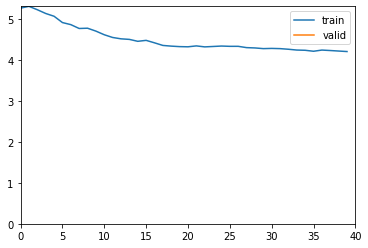

Better model found at epoch 0 with valid_loss value: 4.0424580574035645.


In [66]:
learn.freeze_to(-1)
learn.fit_one_cycle(
    1, 
    max_lr=2e-3,
    moms=(0.8, 0.7),
    wd=0.1,
    callbacks=[
        SaveModelCallback(learn, every='improvement', monitor='valid_loss', name=f"{args.model_name}_dec")
    ]
)

And now we will unfreeze all the layers, drop the learning rate and train again.

epoch,train_loss,valid_loss,seq2seq_acc,time
0,3.674384,4.023995,0.085742,00:15


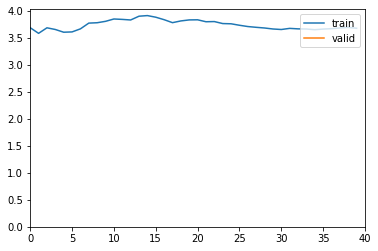

Better model found at epoch 0 with valid_loss value: 4.023995399475098.


In [67]:
learn.unfreeze()
learn.fit_one_cycle(
    1, 
    max_lr=slice(2e-5, 2e-4),
    moms=(0.8, 0.7),
    wd=0.1,
    callbacks=[
        SaveModelCallback(learn, every='improvement', monitor='valid_loss', name=f"{args.model_name}_encdec")
    ]
)

In [68]:
learn = learn.load(f"{args.model_name}_encdec")
torch.save(learn.model.state_dict(), f"../models/{args.model_name}_encdec_weights.pth")

### Inference

So now you want to evaluate how well your model is working. Let's create a function for summarising an article, or group of articles. I won't go into huge detail about how this works since it's a bit of a black box to me still. The _build_predictor()_ function comes from the _modelling_bertabs.py_ in the HuggingFace repo. It constructs a Translator object. It works. You can read through the code there. _format_summary()_ is also from the HuggingFace repo. I've added a few extra .replace()s to remove the white space before punctuation marks. 

In [69]:
def format_summary(translation):
    raw_summary, _, _ = translation
    summary = (raw_summary.replace("[unused0]", "")
                          .replace("[unused3]", "")
                          .replace("[PAD]", "")
                          .replace("[unused1]", "")
                          .replace(r" +", " ")
                          .replace(" [unused2] ", ". ")
                          .replace("[unused2]", "")
                          .replace(" .", ".")
                          .replace(" ,", ",")
                          .replace(" ?", "?")
                          .replace(" !", "!")
                          .strip())
    return summary

In [70]:
def summarise_articles(input_list, tokenizer, symbols, model):
    iterator = DataLoader(
        input_list, 
        sampler=SequentialSampler(input_list), 
        batch_size=min(len(input_list), args.batch_size), 
        collate_fn=partial(
            collate_function, 
            tokenizer=tokenizer, 
            symbols=symbols, 
            block_size=args.block_size, 
            training=False
        ),
        pin_memory=False
    )
    
    summaries = []
    predictor = build_predictor(args, tokenizer, symbols, model)
    for batch in progress_bar(iterator):
        batch_data = predictor.translate_batch(batch)
        translations = predictor.from_batch(batch_data)
        summaries.extend([format_summary(t) for t in translations])
            
    return summaries

You can pass the one of train_ds, valid_ds, or test_ds if you want to evaluate on the dataset. If you want to try out your model on some new articles, paste them into _.txt_ files in a folder. Set _args.stories_folder_ to be the path to that folder. Then use the cell below to make your predictions. 

In [71]:
model = load_model(pretrained=True, path=f"../models/{args.model_name}_encdec_weights.pth")

input_list = []
for file in glob.glob(f"{args.stories_folder}/*.txt"):
    text = open(file).read()
    text = re.sub('\n', '', text)
    text = re.split('(?<=\w[!\?\.])', text) 
    tup = ('', text, [''])
    input_list.append(tup)

summaries = summarise_articles(input_list, tokenizer, symbols, model)

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [72]:
summaries

['university of british columbia researchers have found a cheap, sustainable way to build a solar cell using bacteria that convert light to energy. the research could be a step toward wider adoption of solar power in places like british columbia and parts of northern europe where overcast skies are common. a handful of islamic extremist groups have pledged allegiance to is.']